## TO DO: 
#### Understand what is the source of the perfect training accuracy: 
* data leakage? overfitting? unbalanced dataset? 
* do cross-validation 
* Look at the heatmap of the motor assessments (UPDRS & MSEADLG) to see if there are high correlation with NHY
* Logistic Regression: play on the C parameter
* RF: play on the parameters that can reduce overfitting

* prepare the time-series dataset: sequence length: 4 with min of 2 (rest is padding), with 3 as input. 

## REFERENCES

#### NOTEBOOKS - classic ML
* [DSR- Gerrit- intro to ML] (http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/Machine%20Learning%20-%20DSR%20Intro.ipynb)
* [DSR-Gerrit- Boosting & XGBoost]
http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/Boosting%20and%20XGBoost.ipynb
* [DSR-Gerrit- RF]
(http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/%20RF%20notebooks/DecisionTrees_Intro.ipynb)
* [DSR-Gerrit-Evaluation models] (http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/exercises/Evaluation%20Solutions.ipynb)
* [DSR-Gerrit- Bayesian Learning]
(http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/exercises/Bayesian%20Learning%20Solutions.ipynb)
* [DSR-Rachel-ML Pipelines]
(http://localhost:8889/notebooks/00_TRAINING/02_DSR/10_DSR_Model_Pipelines_Rachel/1.3%20Pipelines%20.ipynb)
#### GITHUB repos: 
* **Hands-On Machine Learning w/scikit-learn and TensorFlow book: https://github.com/AMDonati/handson-ml**
* sci-kit learn: https://github.com/AMDonati/scikit-learn/tree/master/sklearn
* https://github.com/AMDonati/data-science-ipython-notebooks
* Data Science w/ Python handbook: https://github.com/AMDonati/PythonDataScienceHandbook
* https://github.com/AMDonati/machine-learning-cheat-sheet
#### Specific to time-series: 
* https://github.com/ChadFulton/tsa-notebooks
* https://github.com/maxim5/time-series-machine-learning

## FRAMEWORK
3. Preparing the data for the ML algo:
    * Dimensionality reduction? 
    * Standardization/ normalisation? 
    * split train/val/test
    * do something special for the multi-label classification problem?
4. Select and train the model
5. Model Evaluation: 
    * Fine-tune the model
    * Cross-validtion
    * Metrics plotting

## 0. Imports & functions

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.cross_validation as cv
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
!pip install -U imbalanced-learn

  Using cached https://files.pythonhosted.org/packages/80/a4/900463a3c0af082aed9c5a43f4ec317a9469710c5ef80496c9abc26ed0ca/imbalanced_learn-0.3.3-py3-none-any.whl
  Found existing installation: imbalanced-learn 0.3.1
    Uninstalling imbalanced-learn-0.3.1:
      Successfully uninstalled imbalanced-learn-0.3.1


### 1. Building a model: template


#### C = 1/lambda, the parameter of the sigmoid function
#### lambda = 0.001, 0.005, 0.01, 0.05, ..., 1, 5, 10, 50
from sklearn.metrics import classification_report
report = classification_report(y_test, 
                      logreg.predict(X_test), 
                      #labels=data.feature_names,
                      target_names=data.target_names)
print(report)

### Models to train
0. Persistence baseline
1. RF regressor for features importance
2. Logistic Regression for times-series forecast (with sample weighted loss?)
2. RF/ XGBoost for time-series prediction

### About the use of RF as a features importance selector: 
* https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
* https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3
* https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/

### Run a random forest on the 2 possible labels (NHY & MODEADL)
### Take different targets values to see how it evolves. 
### Take also all samples with the mean. 
* DiagFeat
* Non-Motor Assessments
* Motor Assessments
* General Medical Data

# I. Features importance & Non TS classification of Disease Progression

## 1. Data preparation

In [3]:
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns=['EVENT_ID','INFODT'],inplace=True)
#df.set_index(keys=['PATNO'],inplace=True)
df.head()

,PATNO,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,7,2,394,2313,700,0,0
2,3001,2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,7,3,426,1887,1126,0,0
3,3001,2014-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,4,335,1552,1461,0,0
4,3001,2015-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,5,365,1187,1826,0,0


In [4]:
dfAgg=df.groupby('PATNO').agg('median')
dfAgg.drop(columns=['visitsdiff_days','VISIT_ID'],inplace=True)
dfAgg['NHY']=dfAgg['NHY'].apply(lambda x: round(x,0))
dfAgg.head()

,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,7.0,1552.0,1461.0,0.0,0.0
3002,1.0,0.0,1.0,1.0,0.0,0.0,1.5,2.5,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,6.0,1567.5,1504.5,0.0,0.0
3003,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,7.0,1552.0,1857.0,0.0,0.0
3006,0.0,0.0,0.5,1.0,0.0,0.0,2.5,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,2.0,2.0,2465.5,333.5,0.0,0.0
3007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,...,1.0,1.0,0.0,1.0,2.0,1.0,2648.0,90.0,0.0,0.0


In [5]:
dfAgg['NHY'].value_counts()

2.0    692
0.0    683
1.0    203
3.0     69
4.0     24
5.0      3
Name: NHY, dtype: int64

## 2. Split train, test

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfAgg, test_size=0.3, random_state=0)
train.to_pickle("./train_nonTS.pickle")
test.to_pickle("./test_nonTS.pickle")
train.head()

,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
12898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1734.0,0.0,0.0,0.0
41544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,745.5,0.0,0.0,0.0
41284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,455.0,0.0,0.0,0.0
53015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,791.0,0.0,0.0,0.0
4080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,2.0,1.0,2099.0,30.0,0.0,0.0


In [7]:
train.NHY.value_counts()

0.0    478
2.0    475
1.0    147
3.0     51
4.0     18
5.0      2
Name: NHY, dtype: int64

In [8]:
X_train = train.loc[:,train.columns!='NHY']
y_train = train['NHY']
X_test = test.loc[:,train.columns!='NHY']
y_test = test[('NHY')]
X_train.shape

(1171, 371)

In [9]:
y_test.value_counts()

2.0    217
0.0    205
1.0     56
3.0     18
4.0      6
5.0      1
Name: NHY, dtype: int64

### Take care of the classes unbalance

In [10]:
from sklearn.utils import resample

train_majority = train[train.NHY==0.0]
train_minority_1 = train[train.NHY==1.0]
train_minority_2= train[train.NHY==2.0]
train_minority_3= train[train.NHY==3.0]
train_minority_4=train[train.NHY==4.0]
train_minority_5=train[train.NHY==5.0]

# Upsample minority class
train_minority_upsampled_1 = resample(train_minority_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_2 = resample(train_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_3 = resample(train_minority_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_4= resample(train_minority_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_5= resample(train_minority_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled_1,train_minority_upsampled_2,
                             train_minority_upsampled_3,train_minority_upsampled_4,
                             train_minority_upsampled_5])

# Show new class counts
train_upsampled.NHY.value_counts()

5.0    478
4.0    478
3.0    478
2.0    478
1.0    478
0.0    478
Name: NHY, dtype: int64

In [11]:
X_train_up = train_upsampled.loc[:,train.columns!='NHY']
y_train_up= train_upsampled['NHY']

In [55]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
X_resampled.shape
logreg_smote = LogisticRegression(random_state=0).fit(X_resampled, y_resampled)

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
#X_resampled, y_resampled = ADASYN().fit_sample(X, y)
#clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

## 3. Model Training

### Dummy Classifier

In [13]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [14]:
print("Train-Score: %.4f, Test-Accuracy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score: 0.3365, Test-Accuracy: 0.3459


### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
logreg_up=LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=1)
logreg_up.fit(X_train_up, y_train_up)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

### Random Forest

In [18]:
rfc_up = RandomForestClassifier(n_estimators=100, random_state=1)
rfc_up.fit(X_train_up, y_train_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [19]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc.score(X_train, y_train), rfc.score(X_test, y_test)))

Train-Score-rfc: 1.0000, Test-Accuracy-rfc: 0.8728


### feature importance
do a pairplot of the important features in the original dataset

In [34]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures=feature_importances[feature_importances.values>=0.01]
ImportantFeatures

,importance
DOMSIDE,0.062937
PDDXDT_diff_days,0.061990
PRIMDIAG,0.056511
PD_MED_USE,0.030121
DFRIGIDP,0.028758
NP3BRADY,0.027750
NP3FACXP,0.024785
DXBRADY,0.024602
MSEADLG,0.023797
ON_OFF_DOSE,0.023562


In [44]:
feature_importances_up = pd.DataFrame(rfc_up.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures_up=feature_importances_up[feature_importances.values>=0.01]
ImportantFeatures_up

,importance
PDDXDT_diff_days,0.036929
NP3PSTBL,0.036495
NP3GAIT,0.034670
NP3RISNG,0.028487
BIRTHDT,0.022086
MSEADLG,0.021774
NP2WALK,0.021529
NP3LGAGL,0.018049
DOMSIDE,0.017493
NP2DRES,0.017204


In [43]:
import seaborn as sns
ImportantFeatures.index
#sns.barplot(x=ImportantFeatures,y=ImportantFeatures.index, orient="h")

Index(['DOMSIDE', 'PDDXDT_diff_days', 'PRIMDIAG', 'PD_MED_USE', 'DFRIGIDP',
       'NP3BRADY', 'NP3FACXP', 'DXBRADY', 'MSEADLG', 'ON_OFF_DOSE', 'DFRTREMP',
       'DXTREMOR', 'DXRIGID', 'NP3PSTBL', 'DFRIGIDA', 'NP3SPCH', 'NP3LGAGR',
       'NP3RIGLU', 'NP3FTAPL', 'NP3LGAGL', 'DFBRADYP', 'NP3POSTR',
       'lastDate_diff_days', 'NP3PRSPL'],
      dtype='object')

## 4. Evaluation: Calculating, plotting metrics

In [45]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg.score(X_train, y_train), logreg.score(X_test, y_test)))
print("Train-Score-logreg-up: %.4f, Test-Accuracy-logreg-up: %.4f" % (logreg_up.score(X_train_up, y_train_up), logreg_up.score(X_test, y_test)))
print("Train-Score-rfc-up: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_up.score(X_train_up, y_train_up), rfc_up.score(X_test, y_test)))

Train-Score-logreg: 0.9889, Test-Accuracy-logreg: 0.8509
Train-Score-logreg-up: 0.9965, Test-Accuracy-logreg-up: 0.8171
Train-Score-rfc-up: 1.0000, Test-Accuracy-rfc: 0.8986


### Confusion Matrix

In [29]:
y_pred_logreg=logreg.predict(X_test)
cm_logreg=confusion_matrix(y_test,y_pred_logreg)
cm_logreg_df=pd.DataFrame(cm_logreg,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
cm_logreg

array([[200,   4,   1,   0,   0,   0],
       [  5,  24,  26,   1,   0,   0],
       [  2,  13, 196,   6,   0,   0],
       [  0,   0,   9,   5,   3,   1],
       [  0,   0,   0,   3,   3,   0],
       [  0,   0,   0,   0,   1,   0]])

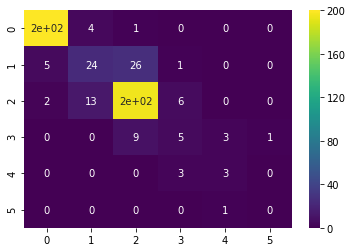

In [30]:
import seaborn as sns
sns.heatmap(cm_logreg_df,annot=True,cmap='viridis')

In [31]:
y_pred_rfc=rfc.predict(X_test)
cm_rfc=confusion_matrix(y_test,y_pred_rfc)
cm_rfc_df=pd.DataFrame(cm_rfc,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
cm_rfc

array([[203,   2,   0,   0,   0,   0],
       [  3,  23,  30,   0,   0,   0],
       [  3,   5, 208,   1,   0,   0],
       [  0,   0,  14,   4,   0,   0],
       [  0,   0,   1,   4,   1,   0],
       [  0,   0,   0,   0,   1,   0]])

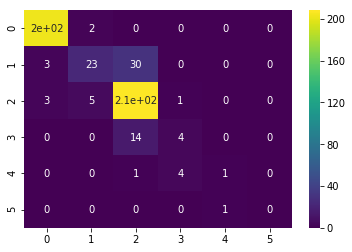

In [32]:
sns.heatmap(cm_rfc_df,annot=True,cmap='viridis')

### classification report

In [48]:
from sklearn.metrics import classification_report
report_logreg = classification_report(y_test, 
                      y_pred_logreg)
print(report_logreg)

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.97       205
        1.0       0.59      0.43      0.49        56
        2.0       0.84      0.90      0.87       217
        3.0       0.33      0.28      0.30        18
        4.0       0.43      0.50      0.46         6
        5.0       0.00      0.00      0.00         1

avg / total       0.84      0.85      0.84       503



In [50]:
report_rfc = classification_report(y_test, 
                      y_pred_rfc)
print(report_rfc)

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       205
        1.0       0.77      0.41      0.53        56
        2.0       0.82      0.96      0.89       217
        3.0       0.44      0.22      0.30        18
        4.0       0.50      0.17      0.25         6
        5.0       0.00      0.00      0.00         1

avg / total       0.86      0.87      0.85       503



In [51]:
y_pred_rfc_up=rfc_up.predict(X_test)
report_rfc_up = classification_report(y_test, 
                      y_pred_rfc_up)
print(report_rfc_up)

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98       205
        1.0       0.76      0.73      0.75        56
        2.0       0.90      0.93      0.91       217
        3.0       0.40      0.33      0.36        18
        4.0       0.00      0.00      0.00         6
        5.0       0.00      0.00      0.00         1

avg / total       0.88      0.90      0.89       503



## 5. Cross-Validation

### Manual implementation

def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = num_samples // k
    
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[i*fold_size:(i+1)*fold_size] = True
        masks.append(mask)
        
    return masks

masks = create_kfold_mask(150, 10)
plt.matshow(masks)

mask = masks[0]
print(X_versi[mask]) # selects the test sample
print(len(X_versi[~mask])) # selects training sample, ~ is binary negation

### random shuffle to avoid class unbalance
`print(y_versi)
num_sample = len(X_versi)
np.random.seed(3)
permutation = np.random.permutation(num_sample)
X_versi, y_versi = X_versi[permutation], y_versi[permutation]`

In [57]:
# Fit the k-fold CV to the classifier
from sklearn.metrics import f1_score
def cv_k_fold_classifier(clf, k, X, y):
    training_scores = []
    test_scores = []
   
    # Your code
    n = len(X)
    masks = create_kfold_mask(n, k)
    
    for mask in masks:
        X_train, y_train = X[~mask], y[~mask]
        clf.fit(X_train, y_train)
        # training_scores.append(clf.score(X_train, y_train))
        training_scores.append(f1_score(clf.predict(X_train), y_train))
        X_test, y_test = X[mask], y[mask]
        # test_scores.append(clf.score(X_test, y_test))
        test_scores.append(f1_score(clf.predict(X_test), y_test))
    
    return training_scores, test_scores

### automatic implementation via the cv sklearn library

In [ ]:
# Other CV methods do not require labels only the length of the labels
plot_cv(cv.KFold(len(y), n_folds=10)) # like we implemented
plot_cv(cv.ShuffleSplit(len(y), n_iter=10, test_size=0.3)) # like training_test_split with test 30% of data

In [ ]:
import sklearn.cross_validation as cv

# Helper to plot scikit CV
def plot_cv(cv):
    masks = []
    for train, test in cv: # this shows you how to use the cv results!
        # i.e. X_train, y_train = X[train], y[train]
        mask = np.zeros(cv.n, dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks)
    
kfold = cv.StratifiedKFold(y, n_folds=10) # using it on the original multi-class labels
plot_cv(kfold)

### example of CV on iris dataset

In [ ]:
# Solution Exercise 2.2

virgin_idx = y == 2
y_virgin = np.zeros(len(y))
y_virgin[virgin_idx] = 1

from sklearn import grid_search
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold

parameters = {
    'kernel':('linear', 'rbf'), 
    'C':[0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
}

svc = SVC()

# a)
clf = grid_search.GridSearchCV(svc, parameters, scoring='accuracy', cv=StratifiedKFold(y_virgin, 2))
clf.fit(X, y_virgin) 

best_clf_a = clf.best_estimator_

y_score = best_clf_a.decision_function(X)
fpr_a, tpr_a, _ = metrics.roc_curve(y_virgin, y_score, pos_label=1)

print("Best Classifier (2-fold): %s" % best_clf_a)
print("Best Accuracy (2-fold): %.4f" % clf.best_score_)
# b)
clf = grid_search.GridSearchCV(svc, parameters, scoring='accuracy', cv=LeaveOneOut(150))
clf.fit(X, y_virgin)   

best_clf_b = clf.best_estimator_

y_score = best_clf_b.decision_function(X)
fpr_b, tpr_b, _ = metrics.roc_curve(y_virgin, y_score, pos_label=1)
plot_roc_curves([fpr_a, fpr_b], [tpr_a, tpr_b])

print("Best Classifier (LOOCV): %s" % best_clf_b)
print("Best Accuracy (LOOCV): %.4f" % clf.best_score_)

### validation curve? 